In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque
import pandas as pd


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [2]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [3]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
dataset.dataset.head()

/workspace/slp_jaspar/autoencoder/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [4]:
labels_order =  dataset.number_of_segments_per_game(60,5000)
print(labels_order)
labels_order = labels_order['Label'].values

             Label   Count   Shift
0              FOX  103069  193497
1            FALCO   90717  168117
2            MARTH   53728  106569
3   CAPTAIN_FALCON   38006   70125
4            SHEIK   27623   59145
5            PEACH   17438   39398
6       JIGGLYPUFF   16374   35581
7            SAMUS    9524   23031
8     ICE_CLIMBERS    6849   15620
9        GANONDORF    6655   12805
10           YOSHI    5725   12226
11           LUIGI    5230   11464
12        DR_MARIO    4202    9062
13         PIKACHU    4096    8991
14            LINK    2502    5598
15            NESS    2306    5812
16     DONKEY_KONG    2026    4333
17  GAME_AND_WATCH    1967    3693
18          MEWTWO    1775    4511
19           MARIO    1713    3824
20      YOUNG_LINK    1447    3278
21             ROY    1272    2685
22          BOWSER     940    2196
23           KIRBY     556    1237
24           PICHU     230     491


In [5]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\FALCO\bee06d45-fca6-437f-969a-901efa166...   28801             1   
1  mango\FALCO\44e0962b-fdf7-4a16-acbe-61b5e5d609...   27200             1   
2  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
3  ranked\FALCO\69cf9bb4-5f80-4e67-850d-ce0d7da1d...   25128             1   
4  ranked\FALCO\04257d15-f02f-4001-a191-37b97d2ed...   24323             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [6]:
train_df, test_df = dataset.all_segments_train_test_split_dataframes(60, proportion_of_segments=1, test_ratio = .2, val = False)
porportion = .8     
train_df = train_df.sample(frac=porportion, random_state = 42)
porportion = .05
test_df = test_df.sample(frac=porportion, random_state = 42)

In [7]:
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))
train_df.head()

(42970042, 6)
(671279, 6)
0.015381729622712384


,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
18418491,ranked\FOX\555c5173-1750-4a33-b785-b38d0ff8aaa...,FOX,5,8142,138,60
25236203,ranked\FOX\cb87e4b2-2873-453d-b039-b0128a6cf86...,FOX,5,5487,93,60
25261750,ranked\FOX\804be79f-5a9f-47ca-bfda-ef5d2b8c06d...,FOX,5,472,8,60
23561687,ranked\FOX\8fee85f6-9cb4-4914-9324-87f8d8e9b5e...,FOX,5,8909,151,60
3974957,public\FALCO\8ea4f120-ad37-40a4-91bb-1aa235e12...,FALCO,4,4956,84,60


In [8]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        
        # separate into positive and negative values
        # if self.transform:
        #     transformed = np.zeros((13,60))
        #     transformed[0,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] > 0)
        #     transformed[1,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] < 0)
        #     transformed[2,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] > 0)
        #     transformed[3,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] < 0)
        #     transformed[4,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] > 0)
        #     transformed[5,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] < 0)
        #     transformed[6,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] > 0)
        #     transformed[7,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] < 0)
        #     transformed[8:,:] = segment[4:]
        #     segment = transformed
        
        # if self.transform:
        #     # Shift inputs: adjusting so that positives are reduced and negatives are increased
        #     segment[0:4, :] -= .2875 * (segment[0:4, :] > 0)
        #     segment[0:4, :] += .2875 * (segment[0:4, :] < 0)

        #     # Scale inputs to be between -.5 and .5
        #     segment[0:4, :] *= 1.40350877193 / 2
        #     segment[0:4, :] += .5
        
        if self.transform:
            transformed = np.zeros((13,60))
            
            # First 4 rows of transformed are the analog inputs transformed to have range [0,1]
            # Shift inputs: adjusting so that positives are reduced and negatives are increased
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875
            analog_transformed[analog_transformed < 0] += 0.2875
            # Scale inputs to be between -.5 and .5
            analog_transformed *= 1.40350877193 / 2
            # Add .5 to so final inputs are between 0 and 1
            analog_transformed += .5
            
            transformed[0:4] = analog_transformed
            # Next four rows are 0 if the corresponding analog input is 0
            transformed[4:8] += 1 - (segment[:4] == 0)
            
            # Transform the Trigger so that it is 0 or 1
            transformed[8] += (segment[-5] > .5)
            
            # Remaining rows are button inputs
            transformed[-4:] += segment[-4:]
            
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(transformed).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df,True)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df,True)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [9]:
# def train_model(model, criterion, optimizer, loaders, device, num_epochs=1, rolling_loss_number=100, patience=99):
#     scaler = GradScaler()
#     best_loss = float('inf')
#     best_model = None
    
#     for epoch in range(num_epochs):
#         model.train()
#         train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
#         rolling_loss = deque(maxlen=rolling_loss_number)
#         rolling_total = deque(maxlen=rolling_loss_number)
        
#         for batch_number, target_cpu in enumerate(train_loader_tqdm):
#             target_gpu = target_cpu.to(device)
#             optimizer.zero_grad()
#             with autocast():
#                 output_gpu = model(target_gpu)
#                 loss = criterion(output_gpu, target_gpu) / (9 * 60 * target_cpu.size(0))
            
#             scaler.scale(loss).backward()
#             scaler.unscale_(optimizer)
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
#             if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
#                 print("Warning: NaN values in gradients!")
#                 bad_targets = check_for_bad_targets(model, criterion, optimizer, target_gpu)
#                 # return bad_targets
#                 continue  # Consider whether to skip or handle differently
                
#             scaler.step(optimizer)
#             scaler.update()
            
#             batch_total = target_gpu.size(0)
#             rolling_total.append(batch_total)
#             current_batch_loss = loss.item()
#             rolling_loss.append(current_batch_loss * target_cpu.size(0))
#             evaluated_rolling_loss = sum(rolling_loss) / sum(rolling_total)
#             train_loader_tqdm.set_postfix(loss=f'{evaluated_rolling_loss:.10f}')
            
#             # if evaluated_rolling_loss < best_loss:
#             #     best_loss = evaluated_rolling_loss
#             #     best_model = model.state_dict()  # Save the best model state
            
#             # if patience <= 0:
#             #     print('Early Stopping.')
#             #     model.load_state_dict(best_model)  # Load the best model state
#             #     return 
            
#             # patience -= 1 if evaluated_rolling_loss >= best_loss else patience  # Only decrement if no improvement

    # return 
            
def train_model_with_virtual_epochs(model, criterion, optimizer, loaders, device, num_epochs=1):
    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
    best_loss = float('inf')
    best_model = None
    
    vepoch_total = 0
    vepoch_loss_sum = 0
    best_vepoch_loss = float('inf')

    early_stopping_patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        virtual_epoch_start_time = time.time()
     
        
        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            optimizer.zero_grad()
            with autocast():
                output_gpu = model(target_gpu)
                loss = criterion(output_gpu, target_gpu) / (13 * 60 * target_cpu.size(0))
            
            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.unscale_(optimizer)
            
            
            if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: NaN values in gradients!")
                bad_targets = check_for_bad_targets(model, criterion, optimizer, target_gpu)
                continue
                
            scaler.step(optimizer)
            scaler.update()
            
            vepoch_total += target_cpu.size(0)
            vepoch_loss_sum += loss.item() * target_cpu.size(0)
            
            if time.time() - virtual_epoch_start_time > 60:
                vepoch_loss = vepoch_loss_sum / vepoch_total
                
                if best_vepoch_loss > vepoch_loss:
                    best_vepoch_loss = vepoch_loss
                else:
                    early_stopping_patience += 1
                    
                train_loader_tqdm.set_postfix(Best=f'{best_vepoch_loss:.10f}', Vepoch=f'{vepoch_loss:.10f}',patience=early_stopping_patience)
                scheduler.step(vepoch_loss)

                # if early_stopping_patience == 0:
                #     return
                    
                virtual_epoch_start_time = time.time()
                vepoch_total = 0
                vepoch_loss_sum = 0
    
    return best_model

def check_for_bad_targets(model, criterion, optimizer, targets_gpu):
    model.train()
    scaler = GradScaler()
    bad_targets = []
    
    try: 
        for i in range(targets_gpu.size(0)):  # Assuming the first dimension is the batch size
            single_target_gpu = targets_gpu[i].unsqueeze(0)  # Maintain batch dimension
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward and loss
            with autocast():
                output_gpu = model(single_target_gpu)
                loss = criterion(output_gpu, single_target_gpu) / (13 * 60)
            
            # Backward
            scaler.scale(loss).backward()
            
            # Check for NaNs in gradients
            if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                bad_targets.append(single_target_gpu.cpu().numpy())  # Move tensor to CPU and convert to numpy
        
        if bad_targets:
            print(f'There were {len(bad_targets)} bad target(s).')
            return bad_targets
        else:
            print('There were no bad targets.')
        return None   
     
    except:
        print('There was a problem evaluating the model on a single target.')
        return targets_gpu
            

def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) / ((32 * 16 * 4) * 13 * 60)
            
            
            total += target_gpu.shape[0] / (32 * 16 * 4)
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (total):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / total:.10f}')
    
def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) 
            
            
            
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (batch_number + 1):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / (batch_number + 1):.10f}')
    

In [10]:
from ResNet_Autoencoder_Model_Baseline_2 import ResNet_Autoencoder

channels = 13

# Build model
model = ResNet_Autoencoder(channels)
model.load_state_dict(torch.load('../../melee_project_data/baseline_2_60s_autoencoder_weights.pt'))
model.to('cuda')
# # With the size of an input we can get a model summary.
summary(model, input_size=(channels, 60))

# Check that the output shape and target shape match
# training_example = torch.rand(9, 2 ** 12).to('cuda')
# print('Target shape:', training_example.shape)
# model.eval()
# output = model(training_example)
# print('Output shape:', output.shape)

## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')
# model = torch.compile(model, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 60]             896
       BatchNorm1d-2               [-1, 64, 60]             128
               ELU-3               [-1, 64, 60]               0
            Conv1d-4               [-1, 64, 60]          12,352
       BatchNorm1d-5               [-1, 64, 60]             128
               ELU-6               [-1, 64, 60]               0
            Conv1d-7              [-1, 256, 60]          16,640
       BatchNorm1d-8              [-1, 256, 60]             512
            Conv1d-9              [-1, 256, 60]           3,584
      BatchNorm1d-10              [-1, 256, 60]             512
              ELU-11              [-1, 256, 60]               0
Encoder_Bottleneck-12              [-1, 256, 60]               0
           Conv1d-13               [-1, 64, 60]          16,448
      BatchNorm1d-14               [-1

In [11]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

torch.autograd.set_detect_anomaly(False)
# Pepare data loaders
batch_size =  32 * 16 * 4
num_workers = 22
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)

# class CustomLoss2(nn.Module):
    # def __init__(self, weight_analog=1.0, weight_digital=1.0):
    #     super(CustomLoss2, self).__init__()
    #     self.BCE = nn.BCEWithLogitsLoss(reduction='sum')  # Consider using weighted BCE if needed
    #     self.MSE = nn.MSELoss(reduction='sum')
    #     self.weight_analog = weight_analog
    #     self.weight_digital = weight_digital

    # def forward(self, pred, target):
    #     # Applying sigmoid to analog outputs to ensure they are in [0, 1]
    #     pred_analog = torch.sigmoid(pred[:4])
    #     target_analog = target[:4]
        
    #     # Calculating losses
    #     mse_loss = self.MSE(pred_analog, target_analog) * self.weight_analog
    #     bce_loss = self.BCE(pred[4:], target[4:]) * self.weight_digital
        
    #     # Total loss
    #     return mse_loss + bce_loss
    
# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.BCE = nn.BCEWithLogitsLoss(reduction='sum')  # Consider using weighted BCE if needed
#         self.MSE = nn.MSELoss(reduction='sum')

#     def forward(self, pred, target):
#         # Calculating losses
#         mse_loss = self.MSE(torch.sigmoid(pred[0:4]), target[0:4]) 
#         bce_loss = self.BCE(pred[4:13], target[4:13])
        
#         # Total loss
#         return mse_loss + bce_loss
    
# class LpLoss(nn.Module):
#     def __init__(self, p):
#         super(LpLoss, self).__init__()
#         self.p = p
#     def forward(self, pred, target):
#         return torch.sum(torch.abs(torch.sigmoid(pred) - target) ** self.p)
    
criterion = nn.MSELoss(reduction = 'sum')
# criterion = CustomLoss()
# 
# criterion = nn.MSELoss(reduction = 'sum')
# criterion = CustomLoss(batch_size)
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 5

# This seems to sometimes help
gc.collect()
torch.cuda.empty_cache()
# Train the model
# start_time = time.time()
# train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# print(f'Batch Size: {batch_size}, Training time: {time.time() - start_time:.2f}')

# Again, this sometimes seems to help
# gc.collect()
# torch.cuda.empty_cache()

# Evaluate the trained model
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

In [12]:
# # optimizer = Adam(model.parameters(), lr=0.0001)
# num_epochs = 10

# # This seems to sometimes help
# gc.collect()
# torch.cuda.empty_cache()
# # Train the model
# # start_time = time.time()
# # train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', num_epochs)

In [13]:
# torch.save(model.state_dict(), '../../melee_project_data/baseline_2_complicated_2_60s_autoencoder_weights.pt')
# torch.save(model, '../../melee_project_data/baseline_2_complicated_2_60s_autoencoder_model.pt')

In [14]:
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

In [15]:
def predict(model, loaders, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit='batch')
        
        for _, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            # output_gpu = torch.sigmoid(output_gpu)
            
            predictions.append(output_gpu.cpu().numpy())
            targets.append(target_cpu.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    

    return predictions, targets

In [16]:
gc.collect()
torch.cuda.empty_cache()

pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 328/328 [00:57<00:00,  5.71batch/s]


In [17]:
def predicted_button_analysis(pred, target):
    buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
    
    # Create dictionary to hold the data
    data = {}
    
    # Process for first frame and last frame for both target and pred
    for index, button in enumerate(buttons):
        data[f'{button}_first_frame_target'] = (target[:, -5+index, 0] > .5).astype(int)
        data[f'{button}_first_frame_pred'] = (pred[:, -5+index, 0] > .5).astype(int)
        data[f'{button}_last_frame_target'] = (target[:, -5+index, -1] > .5).astype(int)
        data[f'{button}_last_frame_pred'] = (pred[:, -5+index, -1] > .5).astype(int)
        
        # Ensure that the dimensions match for prepend operation
        prepend_target = np.expand_dims(target[:, -5+index, 0], axis=1)
        prepend_pred = np.expand_dims(pred[:, -5+index, 0], axis=1)

        transitions_target = np.diff(target[:, -5+index, :], axis=1, prepend=prepend_target)
        transitions_pred = np.diff(pred[:, -5+index, :], axis=1, prepend=prepend_pred)
        
        count_0_to_1_target = np.sum(transitions_target > .5, axis=1)
        count_0_to_1_target += target[:,-5+index,0] > .5
        count_0_to_1_pred = np.sum(transitions_pred > .5, axis=1)
        count_0_to_1_pred += pred[:,-5+index,0] > .5
        
        data[f'{button}_num_presses_target'] = count_0_to_1_target
        data[f'{button}_num_presses_pred'] = count_0_to_1_pred
        
    # Create DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return df

# Example usage:
# Assuming 'pred' and 'target' are defined and appropriate for this function
df = predicted_button_analysis(pred, target)
print(df.describe())
# df.head()

       TRIGGER_LOGICAL_first_frame_target  TRIGGER_LOGICAL_first_frame_pred  \
count                       671279.000000                     671279.000000   
mean                             0.166922                          0.167579   
std                              0.372906                          0.373492   
min                              0.000000                          0.000000   
25%                              0.000000                          0.000000   
50%                              0.000000                          0.000000   
75%                              0.000000                          0.000000   
max                              1.000000                          1.000000   

       TRIGGER_LOGICAL_last_frame_target  TRIGGER_LOGICAL_last_frame_pred  \
count                      671279.000000                    671279.000000   
mean                            0.167255                         0.167382   
std                             0.373204                 

In [18]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
# buttons = ['X_or_Y']


summary_df = pd.DataFrame(np.arange(7,dtype=np.int16),columns=['Target Pressed'])
# print(summary_df)


for index, button in enumerate(buttons):
    print('-----', button, '-----')
    example_data = []
    accuracy_data = []
    under_predicted_data = []
    for i in range(7):
        print()
        print(f'Pressed {i} times')
        df_button_is_pressed = df[df[f'{button}_num_presses_target'] == i]
        columns = [
                    f'{button}_first_frame_target',
                    f'{button}_first_frame_pred',
                    f'{button}_last_frame_target',
                    f'{button}_last_frame_pred',
                    f'{button}_num_presses_target',
                    f'{button}_num_presses_pred']    
        df_button_is_pressed = df_button_is_pressed[columns]
        
        # print(f'Target was pressed {i} time(s): < 0 means under predicting')
        df_button_is_pressed['Off by'] = df_button_is_pressed[f'{button}_num_presses_pred'] - df_button_is_pressed[f'{button}_num_presses_target']
        counts = df_button_is_pressed['Off by'].value_counts().sort_index().to_frame(name='Count')

        # Calculating accuracy
        total_presses = counts['Count'].sum()
        correct_predictions = counts.loc[0, 'Count'] if 0 in counts.index else 0
        accuracy = correct_predictions / total_presses if total_presses > 0 else 0
        print(counts)
        print('Accuracy:', "{:.4f}".format(accuracy))
        accuracy_data += [accuracy]
        
                # Calculating under-prediction rate among non-zero predictions
        under_predicted = counts[counts.index < 0]['Count'].sum() if any(counts.index < 0) else 0
        non_zero_predictions = total_presses - (counts.loc[0, 'Count'] if 0 in counts.index else 0)
        under_prediction_rate = under_predicted / non_zero_predictions if non_zero_predictions > 0 else 0
        print(f'Under-prediction rate: {under_prediction_rate:.4f}')
        under_predicted_data += [under_prediction_rate]
        
        example_data += [df_button_is_pressed.shape[0] / df.shape[0]]
        
    print()
        
    summary_df[f'{button} Examples'] = example_data
    summary_df[f'{button} Correct'] = accuracy_data
    summary_df[f'{button} Under'] = under_predicted_data




----- TRIGGER_LOGICAL -----

Pressed 0 times
    Count
0  281867
1      18
Accuracy: 0.9999
Under-prediction rate: 0.0000

Pressed 1 times
     Count
-1     865
 0  281480
 1     118
Accuracy: 0.9965
Under-prediction rate: 0.8800

Pressed 2 times
    Count
-2     71
-1   1896
 0  93067
 1     70
 2      1
Accuracy: 0.9786
Under-prediction rate: 0.9652

Pressed 3 times
    Count
-3     10
-2     82
-1    886
 0   9840
 1     17
Accuracy: 0.9082
Under-prediction rate: 0.9829

Pressed 4 times
    Count
-4      3
-3     21
-2     55
-1    176
 0    585
 1      1
Accuracy: 0.6956
Under-prediction rate: 0.9961

Pressed 5 times
    Count
-5      1
-4      7
-3     15
-2     24
-1     25
 0     38
Accuracy: 0.3455
Under-prediction rate: 1.0000

Pressed 6 times
    Count
-6      2
-5      4
-4      4
-3      4
-2      5
-1      6
 0      4
Accuracy: 0.1379
Under-prediction rate: 1.0000

----- Z -----

Pressed 0 times
    Count
0  624151
1     124
2       2
Accuracy: 0.9998
Under-prediction rate

In [19]:
print('Table shows:')
print('- The percentage of test examples that were actually pressed n times.')
print('- Accuracy of the prediction given the button was pressed n times.')
print('- Under prediction rate of an incorrect prediction given the button was pressed n times.')           
summary_df

Table shows:
- The percentage of test examples that were actually pressed n times.
- Accuracy of the prediction given the button was pressed n times.
- Under prediction rate of an incorrect prediction given the button was pressed n times.


,Target Pressed,TRIGGER_LOGICAL Examples,TRIGGER_LOGICAL Correct,TRIGGER_LOGICAL Under,Z Examples,Z Correct,Z Under,A Examples,A Correct,A Under,B Examples,B Correct,B Under,X_or_Y Examples,X_or_Y Correct,X_or_Y Under
0,0,0.419922,0.999936,0.000000,0.929981,0.999798,0.000000,0.664876,0.999841,0.000000,0.774156,0.999607,0.000000,0.383006,0.999658,0.000000
1,1,0.420783,0.996520,0.879959,0.058774,0.910605,0.990077,0.218245,0.958390,0.959974,0.166765,0.956202,0.894758,0.396677,0.953587,0.686301
2,2,0.141677,0.978571,0.965162,0.007599,0.785728,0.994511,0.074672,0.926465,0.974227,0.039155,0.915538,0.940541,0.175064,0.911068,0.839633
3,3,0.016141,0.908168,0.982915,0.002199,0.688347,0.993478,0.026017,0.883080,0.982370,0.011934,0.856572,0.975631,0.033262,0.865863,0.909182
4,4,0.001253,0.695600,0.996094,0.000901,0.656198,0.990385,0.010112,0.839570,0.988062,0.004555,0.822433,0.968692,0.007142,0.836045,0.965649
5,5,0.000164,0.345455,1.000000,0.000285,0.565445,1.000000,0.003554,0.763621,0.994681,0.001810,0.767901,0.989362,0.002620,0.808982,0.970238
6,6,0.000043,0.137931,1.000000,0.000145,0.577320,1.000000,0.001484,0.718876,0.996429,0.000871,0.707692,0.982456,0.001351,0.779493,0.990000


In [20]:
import pandas as pd
import numpy as np

buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

first_and_last_df = pd.DataFrame(buttons, columns=['Button'])
for index, button in enumerate(buttons):
    first_frame_0 = (df[f'{button}_first_frame_target'] == 0)
    last_frame_0 = (df[f'{button}_last_frame_target'] == 0)
    
    first_and_last_df.loc[index, 'Ratio target[0]==0'] = first_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[0]==0'] = 1 - df.loc[first_frame_0, f'{button}_first_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[0]==1'] = df.loc[~first_frame_0, f'{button}_first_frame_pred'].mean()
    
    first_and_last_df.loc[index, 'Ratio target[-1]==0'] = last_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[-1]==0'] = 1-df.loc[last_frame_0, f'{button}_last_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[-1]==1'] = df.loc[~last_frame_0, f'{button}_last_frame_pred'].mean()
    
print('Table shows:')
print('- Percentage of test examples where the button was not pressed on the first or last frame')
print('- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.')

first_and_last_df


Table shows:
- Percentage of test examples where the button was not pressed on the first or last frame
- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.


,Button,Ratio target[0]==0,Acc target[0]==0,Acc target[0]==1,Ratio target[-1]==0,Acc target[-1]==0,Acc target[-1]==1
0,TRIGGER_LOGICAL,0.833078,0.998709,0.997492,0.832745,0.998825,0.994905
1,Z,0.990826,0.999904,0.761611,0.990782,0.999902,0.909825
2,A,0.937960,0.999500,0.888225,0.937503,0.999498,0.940934
3,B,0.955071,0.999819,0.839224,0.955196,0.999312,0.969577
4,X_or_Y,0.901242,0.999438,0.891649,0.901464,0.999471,0.810311


Given the target button was pressed once and the prediction was pressed once. How big was the difference in length of the button press. TO DO: further restrict to the prediction being pressed for the same number of frames and seeing if it was pressed at the exact same time.

TRIGGER_LOGICAL
[[    -5      1]
 [    -4      1]
 [    -3      2]
 [    -2     85]
 [    -1   8953]
 [     0 270835]
 [     1   1568]
 [     2     18]
 [     3      9]
 [     4      6]
 [     5      2]]


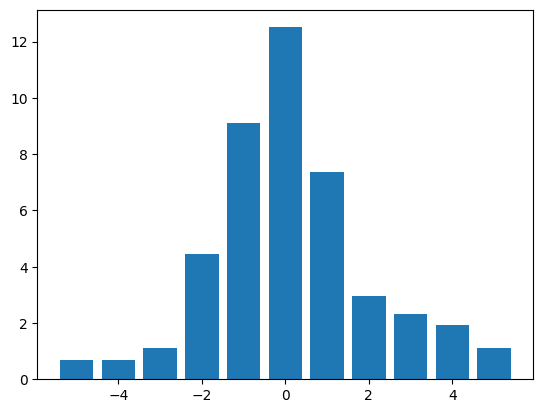

Z
[[   -4     4]
 [   -3    12]
 [   -2   294]
 [   -1  3292]
 [    0 32033]
 [    1   257]
 [    2    27]
 [    4     1]
 [    5     2]
 [    7     2]
 [   15     1]
 [   19     1]
 [   26     1]]


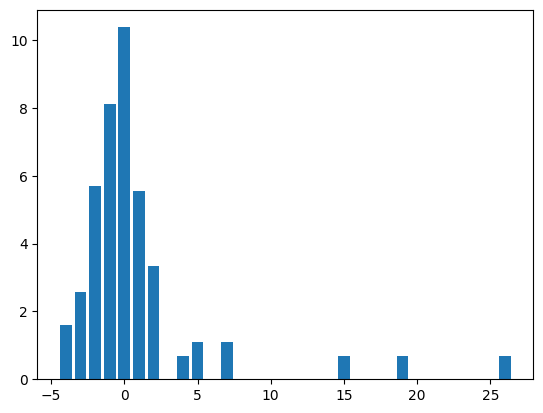

A
[[  -11     1]
 [   -7     3]
 [   -5     1]
 [   -4     6]
 [   -3    32]
 [   -2  6808]
 [   -1 33319]
 [    0 99820]
 [    1   385]
 [    2    19]
 [    3     2]
 [    4     4]
 [    5     1]
 [   19     1]
 [   21     1]
 [   22     1]
 [   28     1]
 [   32     1]
 [   36     1]]


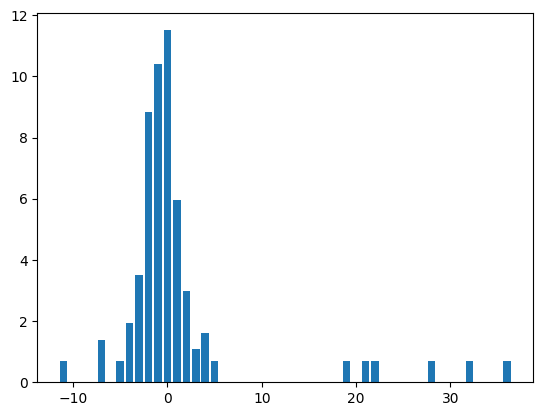

B
[[   -7     1]
 [   -6     2]
 [   -5    11]
 [   -4    25]
 [   -3    73]
 [   -2  2089]
 [   -1 20877]
 [    0 82653]
 [    1  1249]
 [    2    23]
 [    3    10]
 [    4     6]
 [    5     1]
 [    6     4]
 [    7     2]
 [    8     1]
 [    9     2]
 [   13     1]
 [   14     1]
 [   17     1]
 [   25     2]
 [   27     1]
 [   28     1]
 [   31     2]
 [   34     1]
 [   35     1]
 [   36     1]
 [   43     1]
 [   55     1]]


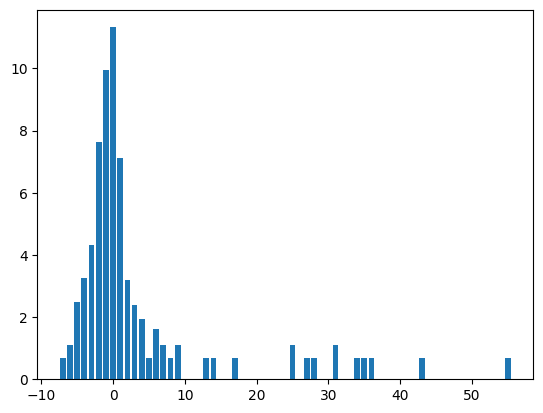

X_or_Y
[[    -5      1]
 [    -4      4]
 [    -3     44]
 [    -2   7102]
 [    -1  67535]
 [     0 178454]
 [     1    731]
 [     2     18]
 [     3      4]
 [     4      3]
 [     5      5]
 [     6      1]
 [    10      1]
 [    12      1]
 [    13      1]
 [    14      2]
 [    15      2]
 [    18      2]
 [    22      1]
 [    24      1]
 [    25      1]
 [    27      1]
 [    28      1]
 [    29      1]
 [    34      1]
 [    42      1]
 [    59      3]]


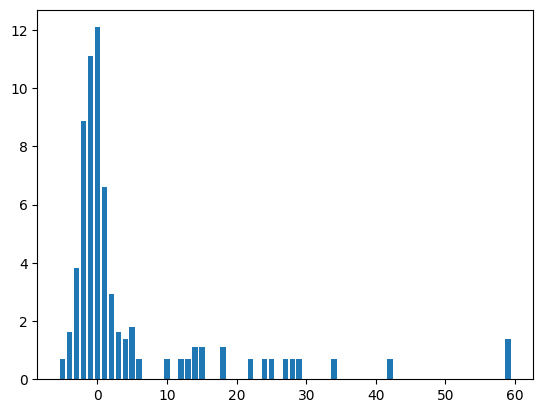

In [21]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
results = []

for index, button in enumerate(buttons):
    button_is_pressed_once = (df[f'{button}_num_presses_target'] == 1) & (df[f'{button}_num_presses_pred'] == 1)
    
    
    # Filtering rows where the button was pressed exactly once in both target and prediction
    target_button_is_pressed_once = target[button_is_pressed_once, -5+index, :]
    pred_button_is_pressed_once = pred[button_is_pressed_once, -5+index, :]
    
    # Calculating indices for the first and last button press in the target and prediction for each example
    index_of_first_1_target = np.argmax(target_button_is_pressed_once > 0.5, axis=1)
    index_of_first_1_pred = np.argmax(pred_button_is_pressed_once > 0.5, axis=1)
    index_of_last_1_target = (target_button_is_pressed_once.shape[1] - np.argmax(target_button_is_pressed_once[:, ::-1] > 0.5, axis=1))
    index_of_last_1_pred = (pred_button_is_pressed_once.shape[1] - np.argmax(pred_button_is_pressed_once[:, ::-1] > 0.5, axis=1))

    length_of_target_press = index_of_last_1_target - index_of_first_1_target
    length_of_pred_press = index_of_last_1_pred - index_of_first_1_pred
    
    unique, count = np.unique(length_of_pred_press - length_of_target_press, return_counts=True)
    print(button)
    print(np.array([unique,count]).T)

    plt.bar(unique,np.log(count+1))
    plt.show()
    


Investigate the differece in the angle of the joystick and c-stick.h

In [22]:
# # Transform the target back to the the standard stick input. 
# # 9 channels
# target_no_transform = target[:, :4, :] - .5
# target_no_transform[0:4, :] /= 1.40350877193 / 2
# target_no_transform -= .2875 * (target_no_transform[:, 0:4, :] < 0)
# target_no_transform += .2875 * (target_no_transform[:, 0:4, :] > 0)
# target_no_transform *= target[:,4:8,:]
 
# predicted_no_transform = pred[:, :4, :] - .5
# predicted_no_transform[0:4, :] /= 1.40350877193 / 2
# predicted_no_transform -= .2875 * (predicted_no_transform[:, 0:4, :] < 0)
# predicted_no_transform += .2875 * (predicted_no_transform[:, 0:4, :] > 0)
# predicted_no_transform *= pred[:,4:8,:]

# target_angle_JSTICK = np.arctan2(target_no_transform[:,0,:], target_no_transform[:,1,:]) * 180 / np.pi
# predicted_angle_JSTICK = np.arctan2(predicted_no_transform[:,0,:], predicted_no_transform[:,1,:]) * 180 / np.pi

# target_radius_JSTICK = np.sqrt(target_no_transform[:,0,:] ** 2 + target_no_transform[:,1,:] ** 2)
# pred_radius_JSTICK = np.sqrt(predicted_no_transform[:,0,:] ** 2 + predicted_no_transform[:,1,:] ** 2)

# print(target_no_transform[:,0,:])
# # # print(target_no_transform[:,1,:])
# print()

# print(predicted_no_transform[:,0,:])
# # # print(predicted_no_transform[:,1,:])
# # print()

# # print(target_angle_JSTICK)
# # print(predicted_angle_JSTICK)
# # print()

# # print(target_radius_JSTICK)
# # print(pred_radius_JSTICK)

Trasform the stick predictions back to the original inputs.

In [65]:
target_sticks_no_transform = target[:, :4] - .5
target_sticks_no_transform /= 1.40350877193 / 2
target_sticks_no_transform[target_sticks_no_transform < 0] -= .2875 
target_sticks_no_transform[target_sticks_no_transform < 0] += .2875
 
predicted_sticks_no_transform = pred[:, :4] - .5
predicted_sticks_no_transform /= 1.40350877193 / 2
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] -= .2875 
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] += .2875

# Multiply by 0 where the model predicted the stick input to be 0
predicted_sticks_no_transform *= (pred[:,4:8] > .5)
predicted_sticks_no_transform = np.where(predicted_sticks_no_transform == 0.0, 0.0, predicted_sticks_no_transform)

target_angle_JSTICK = np.arctan2(target_sticks_no_transform[:,[1,3]], target_sticks_no_transform[:,[0,2]]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_sticks_no_transform[:,[1,3]], predicted_sticks_no_transform[:,[0,2]]) * 180 / np.pi

angle_difference_no_transform = (predicted_angle_JSTICK - target_angle_JSTICK) 
smallest_angle_difference_no_transform = (angle_difference_no_transform + 180) % 360 - 180

target_radius_squared_no_transform = target_sticks_no_transform[:,[0,2]] ** 2 + target_sticks_no_transform[:,[1,3]] ** 2
pred_radius_squared_no_transform = predicted_sticks_no_transform[:,[0,2]] ** 2 + predicted_sticks_no_transform[:,[1,3]] ** 2

radius_difference_no_trasform = target_radius_squared_no_transform - pred_radius_squared_no_transform

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference_no_transform[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference_no_transform[:,1])))

print('JSTICK average radius', np.average(np.abs(radius_difference_no_trasform[:,0])))
print('CSTICK average radius', np.average(np.abs(radius_difference_no_trasform[:,1])))


JSTICK average angle 2.735158
CSTICK average angle 0.4362916
JSTICK average radius 0.03758354
CSTICK average radius 0.0048903665


Check how accurately the model predicted model predicted each analog input being zero.

In [24]:
correct_zero_stick = (pred[:,4:8] == target[:,4:8])
print('Accuracy of JSTICK_X = 0:', np.sum(correct_zero_stick[:,0]) / np.product(pred[:,0].shape) * 100)
print('Accuracy of JSTICK_Y = 0:', np.sum(correct_zero_stick[:,1]) / np.product(pred[:,0].shape) * 100)
print('Accuracy of CSTICK_X = 0:', np.sum(correct_zero_stick[:,2]) / np.product(pred[:,0].shape) * 100)
print('Accuracy of JSTICK_Y = 0:', np.sum(correct_zero_stick[:,3]) / np.product(pred[:,0].shape) * 100)

Accuracy of JSTICK_X = 0: 99.72284251406643
Accuracy of JSTICK_Y = 0: 99.674983625785
Accuracy of CSTICK_X = 0: 99.85515709563386
Accuracy of JSTICK_Y = 0: 99.86762583069037


In [25]:
target_angle_JSTICK = np.arctan2(target_sticks_no_transform[:,0,:], target_sticks_no_transform[:,1,:]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_sticks_no_transform[:,0,:], predicted_sticks_no_transform[:,1,:]) * 180 / np.pi

# values= np.unique(target_angle_JSTICK)
# print(values)

JSTICK_angle_difference = (predicted_angle_JSTICK - target_angle_JSTICK) 
smallest_JSTICK_angle_difference = (JSTICK_angle_difference + 180) % 360 - 180
n = 1
# print(target_sticks_no_transform[n,0])
# print(target_sticks_no_transform[n,1])
# print(1 - (target[n,4] == 1) * (target[n,5] == 1))
# print(target_angle_JSTICK[n])
# print()
# # print(predicted_sticks_no_transform[n,0])
# # print(predicted_sticks_no_transform[n,1])
# print(1 - (pred[n,4] == 1) * (pred[n,5] == 1))
# print(predicted_angle_JSTICK[n])
# print()
# print(JSTICK_angle_difference[n])
# target_radius_JSTICK = np.sqrt(target_no_transform[:,0,:] ** 2 + target_no_transform[:,1,:] ** 2)
# pred_radius_JSTICK = np.sqrt(predicted_no_transform[:,0,:] ** 2 + predicted_no_transform[:,1,:] ** 2)

# print(smallest_JSTICK_angle_difference[n])



[  90.         90.         90.         90.         90.         90.
   90.         90.         90.         90.         90.         90.
   90.         92.20259    99.09027   104.03623   109.17901   110.69545
  110.69545   111.8014    105.15406    90.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.         90.         90.         90.         90.         90.
   90.         90.         90.         92.20259    93.301865  101.534615
  123.69006   143.61565  -151.29404  -133.2643   -133.2643   -129.80557
 -128.08878  -122.00537  -113.35556  -101.534615  -93.301865  -90.
  -90.        -90.        -90.          0.          0.          0.      ]
[  90.         90.         90.         90.         90.         90.
   90.         90.         90.         90.         90.         90.
   90.         91.2913     95.845436  100.03944   102.635956  105.87255
  108.3744    106.48276    95.608246   90.          0.          0.
    0.          0.          0.    

In [27]:
gc.collect()
torch.cuda.empty_cache()

pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 328/328 [00:46<00:00,  7.13batch/s]


In [36]:
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

for i in range(4):
    # bce = log_loss(target[:,i,:].flatten(),pred[:,i,:].flatten())
    mse = mean_squared_error(target[:,i,:].flatten(),pred[:,i,:].flatten())
    print('input',i)
    # print('BCE', bce)
    print('MSE', mse)
    print()
    
for i in range(4,13):
    bce = log_loss(target[:,i,:].flatten(),pred[:,i,:].flatten())
    mse = mean_squared_error(target[:,i,:].flatten(),pred[:,i,:].flatten())
    print('input',i)
    print('BCE', bce)
    print('MSE', mse)
    print()

input 0
MSE 0.0025101246

input 1
MSE 0.0016928131

input 2
MSE 0.0005146101

input 3
MSE 0.0006452597

input 4
BCE 0.0254044934258363
MSE 0.0030596177

input 5
BCE 0.018148900799287555
MSE 0.0027572268

input 6
BCE 0.01185297787910739
MSE 0.0013353667

input 7
BCE 0.00623941025660493
MSE 0.0011063458

input 8
BCE 0.011352076268913205
MSE 0.000841106

input 9
BCE 0.003146740100034065
MSE 0.0004005649

input 10
BCE 0.019349793211912127
MSE 0.002679755

input 11
BCE 0.010163735801211961
MSE 0.0016366695

input 12
BCE 0.03219717230195465
MSE 0.0054070363



In [96]:
target_angle = np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2) #* 180 / np.pi
predicted_angle = np.arctan2((pred[:,[0,2]] - .5) * 2, (pred[:,[1,3]] - .5) * 2) #* 180 / np.pi
# predicted_angle = np.arctan2(pred[:,[0,2]], pred[:,[1,3]]) * 180 / np.pi

angle_difference = (predicted_angle - target_angle) # between -2pi and 2pi
smallest_angle_difference = (angle_difference + np.pi) % (2 * np.pi) - np.pi
# smallest_angle_difference = (angle_difference + 180) % 360 - 180=

# n,i = 4,0
# print(target_angle[n,i])
# print()
# print(predicted_angle[n,i])
# print()
# print(smallest_angle_difference[n,i])

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference[:,1])))

JSTICK average angle 0.31938794
CSTICK average angle 0.5064823


In [98]:
target_angle = np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2) * 180 / np.pi
predicted_angle = np.arctan2((pred[:,[0,2]] - .5) * 2, (pred[:,[1,3]] - .5) * 2) * 180 / np.pi
# predicted_angle = np.arctan2(pred[:,[0,2]], pred[:,[1,3]]) * 180 / np.pi

angle_difference = (predicted_angle - target_angle) # between -2pi and 2pi
# smallest_angle_difference = (angle_difference + np.pi) % (2 * np.pi) - np.pi
smallest_angle_difference = (angle_difference + 180) % 360 - 180
smallest_angle_difference *= (np.pi / 180)

# n,i = 4,0
# print(target_angle[n,i])
# print()
# print(predicted_angle[n,i])
# print()
# print(smallest_angle_difference[n,i])

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference[:,1])))

JSTICK average angle 0.31938794
CSTICK average angle 0.5064823


JSTICK average angle 0.31938794
CSTICK average angle 0.5064823


In [62]:
target_radius_squared = target[:,[0,2]] ** 2 + target[:,[1,3]] ** 2
pred_radius_squared = pred[:,[0,2]] ** 2 + pred[:,[1,3]] ** 2

radius_difference = target_radius_squared - pred_radius_squared

print('JSTICK average radius', np.average(np.abs(radius_difference[:,0])))
print('CSTICK average radius', np.average(np.abs(radius_difference[:,1])))

JSTICK average radius 0.04023463
CSTICK average radius 0.022831393


In [86]:
unique_values = np.unique((target[:,0] - .5) * 2)
print(unique_values.shape)
print(np.diff(unique_values))



(115,)
[0.01754379 0.01754391 0.01754391 0.01754379 0.01754391 0.01754379
 0.01754391 0.01754391 0.01754373 0.01754397 0.01754373 0.01754391
 0.01754397 0.01754373 0.01754391 0.01754379 0.01754391 0.01754391
 0.01754379 0.01754385 0.01754385 0.01754385 0.01754391 0.01754385
 0.01754385 0.01754385 0.01754385 0.01754391 0.01754379 0.01754391
 0.01754379 0.01754385 0.01754397 0.01754379 0.01754385 0.01754385
 0.01754385 0.01754391 0.01754385 0.01754379 0.01754391 0.01754385
 0.01754385 0.01754391 0.01754379 0.01754385 0.01754391 0.01754385
 0.01754385 0.01754385 0.01754385 0.01754385 0.01754385 0.01754391
 0.01754385 0.01754379 0.01754391 0.01754391 0.01754379 0.01754391
 0.01754379 0.01754391 0.01754391 0.01754379 0.01754379 0.01754391
 0.01754391 0.01754379 0.01754391 0.01754379 0.01754391 0.01754379
 0.01754391 0.01754391 0.01754379 0.01754379 0.01754403 0.01754379
 0.01754379 0.01754391 0.01754379 0.01754391 0.01754391 0.01754379
 0.01754391 0.01754379 0.01754391 0.01754391 0.01754379

In [100]:
import math
print((2 * np.pi) * .017545)
print((2 * np.pi) * .017545 * math.sqrt(2))


0.11023848621446584
0.15590076229997707


In [81]:
unique_values = np.unique(np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2))
print(unique_values.shape)
print(np.diff(unique_values))
print(np.average(np.diff(unique_values)))

(5904,)
[0.00036263 0.00037694 0.0003922  ... 0.00037694 0.00036263 0.01886582]
0.0010612095


In [80]:
unique_values = np.unique(target_sticks_no_transform)
print(unique_values.shape)
print(np.diff(unique_values))
print(np.average(np.diff(unique_values)))

(115,)
[0.01249993 0.01250005 0.01250005 0.01249993 0.01250005 0.01249993
 0.01250005 0.01250005 0.01249993 0.01250005 0.01249993 0.01250005
 0.01250005 0.01249993 0.01250005 0.01249993 0.01250005 0.01250002
 0.01249993 0.01250005 0.01249999 0.01249999 0.01250005 0.01249999
 0.01249999 0.01249999 0.01249999 0.01250005 0.01249993 0.01250005
 0.01249999 0.01249999 0.01250005 0.01249999 0.01249999 0.01249999
 0.01249999 0.01250005 0.01249999 0.01249999 0.01249999 0.01250002
 0.01249999 0.01250002 0.01249999 0.01249999 0.01250002 0.01250002
 0.01249999 0.01249999 0.01249999 0.01249999 0.01250002 0.01250002
 0.01250002 0.01249993 0.01250005 0.01250004 0.01249995 0.01250004
 0.01249995 0.01250004 0.01250004 0.01249995 0.01249995 0.01250004
 0.01250003 0.01249996 0.01250003 0.01249996 0.01250003 0.01249996
 0.01250003 0.01250003 0.01249996 0.01249994 0.01250012 0.01249996
 0.01249996 0.01250002 0.01249996 0.01250005 0.01250002 0.01249996
 0.01250005 0.01249996 0.01250002 0.01250005 0.01249996

In [ ]:
.017343 / 2